In [13]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [14]:
n_wires = 4

# Generate sawtooth function values
num_basis_states = 2**n_wires
x_vals = np.linspace(0, 2 * np.pi, num_basis_states, endpoint=False)  # 16 points
sawtooth_vals = x_vals - np.pi  # Apply f(x) = x - π

# Normalize to get valid amplitudes
norm = np.sqrt(np.sum(sawtooth_vals ** 2))
amplitudes = sawtooth_vals / norm

print("Normalized amplitudes:", np.round(amplitudes, 3))

# Compute the squared amplitudes and make them positive
amplitudes_squared = np.abs(amplitudes ** 2)
print("Amplitudes squared and positive:", amplitudes_squared)

Normalized amplitudes: [-0.431 -0.377 -0.323 -0.27  -0.216 -0.162 -0.108 -0.054  0.     0.054
  0.108  0.162  0.216  0.27   0.323  0.377]
Amplitudes squared and positive: [0.18604651 0.14244186 0.10465116 0.07267442 0.04651163 0.02616279
 0.01162791 0.00290698 0.         0.00290698 0.01162791 0.02616279
 0.04651163 0.07267442 0.10465116 0.14244186]


In [15]:
# Classical Fourier Transform of the sawtooth wave
classical_fft = np.fft.fft(sawtooth_vals)
classical_probs = np.abs(classical_fft) ** 2
classical_probs /= np.sum(classical_probs)  # Normalize probabilities

Prepared state probabilities: [0.01162791 0.30551328 0.07940032 0.03767243 0.02325581 0.01681933
 0.01362294 0.01208798 0.01162791 0.01208798 0.01362294 0.01681933
 0.02325581 0.03767243 0.07940032 0.30551328]


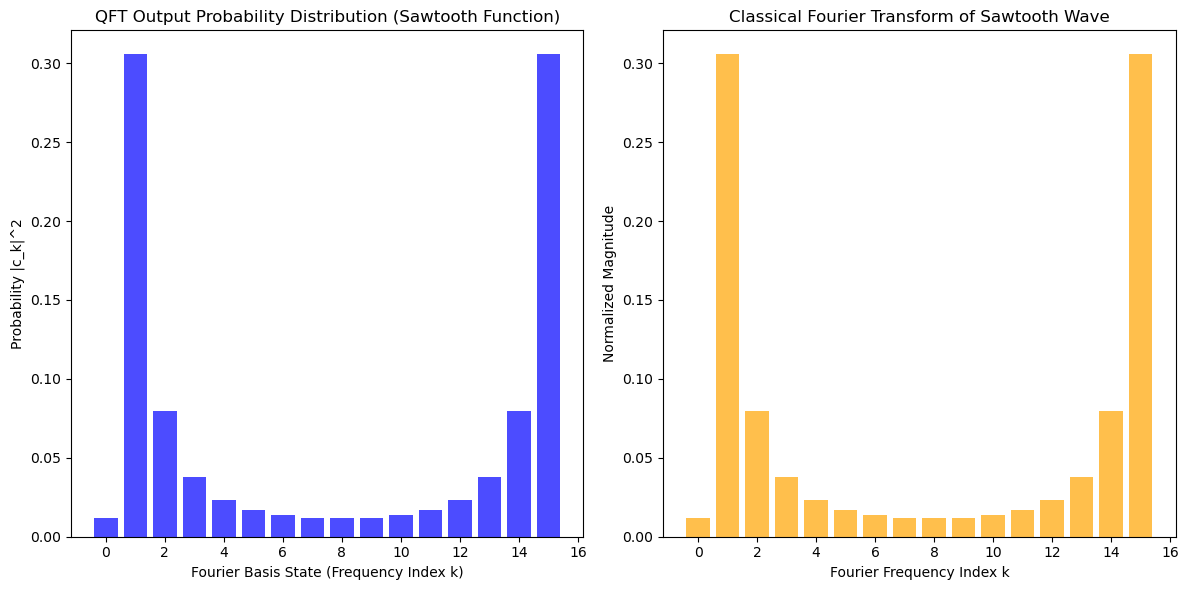

In [16]:
dev = qml.device("lightning.qubit", wires=n_wires)

@qml.qnode(dev)
def state_preparation():

    """Prepare the sawtooth state using gates.
       Use layering system to encode all 16 basis states
       First rotation returns both state positive
       -this is changed at end with global rotation"""

    # First layer: Encode the first qubit
    theta_0_1 = 2 * np.arccos(np.sqrt(np.sum(amplitudes[:8]**2)))
    qml.RY(theta_0_1, wires=0)

    # Second layer: Controlled rotations for the second qubit
    theta_00_01 = 2 * np.arccos(np.sqrt(np.sum(amplitudes[:4]**2) / np.sum(amplitudes[:8]**2)))
    qml.PauliX(wires=0)
    qml.CRY(theta_00_01, wires=[0, 1])
    qml.PauliX(wires=0)
    
    theta_10_11 = 2 * np.arccos(np.sqrt(np.sum(amplitudes[8:12]**2) / np.sum(amplitudes[8:16]**2)))
    qml.CRY(theta_10_11, wires=[0, 1])

    # Third layer: Multi-controlled rotations for the third qubit
    theta_000_001 = 2 * np.arccos(np.sqrt(np.sum(amplitudes[:2]**2) / np.sum(amplitudes[:4]**2)))
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    qml.ctrl(qml.RY, control=[0, 1])(theta_000_001, wires=2)
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)

    theta_010_011 = 2 * np.arccos(np.sqrt(np.sum(amplitudes[4:6]**2) / np.sum(amplitudes[4:8]**2)))
    qml.PauliX(wires=0)
    qml.ctrl(qml.RY, control=[0, 1])(theta_010_011, wires=2)
    qml.PauliX(wires=0)
    
    theta_100_101 = 2 * np.arccos(np.sqrt(np.sum(amplitudes[8:10]**2) / np.sum(amplitudes[8:12]**2)))
    qml.PauliX(wires=1)
    qml.ctrl(qml.RY, control=[0, 1])(theta_100_101, wires=2)
    qml.PauliX(wires=1)

    theta_110_111 = 2 * np.arccos(np.sqrt(np.sum(amplitudes[12:14]**2) / np.sum(amplitudes[12:16]**2)))
    qml.ctrl(qml.RY, control=[0, 1])(theta_110_111, wires=2)
    
    # Fourth layer: Rotate the fourth qubit multi controlled
    theta_0000_0001 = 2 * np.arccos(np.sqrt(np.sum(amplitudes[:1]**2) / np.sum(amplitudes[:2]**2)))
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    qml.PauliX(wires=2)
    qml.ctrl(qml.RY, control=[0, 1, 2])(theta_0000_0001, wires=3)
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    qml.PauliX(wires=2)

    theta_0010_0011 = 2 * np.arccos(np.sqrt(np.sum(amplitudes[2:3]**2) / np.sum(amplitudes[2:4]**2)))
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    qml.ctrl(qml.RY, control=[0, 1, 2])(theta_0010_0011, wires=3)
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)

    theta_0100_0101 = 2 * np.arccos(np.sqrt(np.sum(amplitudes[4:5]**2) / np.sum(amplitudes[4:6]**2)))
    qml.PauliX(wires=0)
    qml.PauliX(wires=2)
    qml.ctrl(qml.RY, control=[0, 1, 2])(theta_0100_0101, wires=3)
    qml.PauliX(wires=0)
    qml.PauliX(wires=2)

    theta_0110_0111 = 2 * np.arccos(np.sqrt(np.sum(amplitudes[6:7]**2) / np.sum(amplitudes[6:8]**2)))
    qml.PauliX(wires=0)
    qml.ctrl(qml.RY, control=[0, 1, 2])(theta_0110_0111, wires=3)
    qml.PauliX(wires=0)

    theta_1000_1001 = 2 * np.arccos(np.sqrt(np.sum(amplitudes[8:9]**2) / np.sum(amplitudes[8:10]**2)))
    qml.PauliX(wires=1)
    qml.PauliX(wires=2)
    qml.ctrl(qml.RY, control=[0, 1, 2])(theta_1000_1001, wires=3)
    qml.PauliX(wires=1)
    qml.PauliX(wires=2)

    theta_1010_1011 = 2 * np.arccos(np.sqrt(np.sum(amplitudes[10:11]**2) / np.sum(amplitudes[10:12]**2)))
    qml.PauliX(wires=1)
    qml.ctrl(qml.RY, control=[0, 1, 2])(theta_1010_1011, wires=3)
    qml.PauliX(wires=1)

    theta_1100_1101 = 2 * np.arccos(np.sqrt(np.sum(amplitudes[12:13]**2) / np.sum(amplitudes[12:14]**2)))
    qml.PauliX(wires=2)
    qml.ctrl(qml.RY, control=[0, 1, 2])(theta_1100_1101, wires=3)
    qml.PauliX(wires=2)

    theta_1110_1111 = 2 * np.arccos(np.sqrt(np.sum(amplitudes[14:15]**2) / np.sum(amplitudes[14:16]**2)))
    qml.ctrl(qml.RY, control=[0, 1, 2])(theta_1110_1111, wires=3)  
    
    #Apply global phase to first 8 states to make them negative, as is in sawtooth wave
    qml.PauliX(wires=0)
    qml.ctrl(qml.GlobalPhase, control=0)(np.pi,wires=1)
    qml.PauliX(wires=0)
    
    qml.QFT(wires=range(n_wires))
    
    return qml.probs()

# Execute the state preparation circuit
prepared_probs = state_preparation()

print("Prepared state probabilities:", prepared_probs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Quantum Fourier Transform output
ax1.bar(range(len(prepared_probs)), prepared_probs, color='blue', alpha=0.7)
ax1.set_title("QFT Output Probability Distribution (Sawtooth Function)")
ax1.set_xlabel("Fourier Basis State (Frequency Index k)")
ax1.set_ylabel("Probability |c_k|^2")

# Classical Fourier Transform output
ax2.bar(range(len(classical_probs)), classical_probs, color='orange', alpha=0.7)
ax2.set_title("Classical Fourier Transform of Sawtooth Wave")
ax2.set_xlabel("Fourier Frequency Index k")
ax2.set_ylabel("Normalized Magnitude")

plt.tight_layout()
plt.show()